In [66]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
data_dir = '../data/mnist'
apply_transform = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))]) #old: (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
#ref: https://stackoverflow.com/questions/55124407/output-and-broadcast-shape-mismatch-in-mnist-torchvision
train_dataset = datasets.MNIST(data_dir, train=True, download=True,
                                       transform=apply_transform)

In [67]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torch
import numpy as np
class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image , label # torch.tensor(image), torch.tensor(label)

In [68]:
def mnist_iid(dataset, num_users):
    """
    Sample I.I.D. client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {},list(range(train_dataset.targets.shape[0])) #old: [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [89]:
def mnist_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    # 60,000 training imgs -->  200 shard X 300 imgs/shards
    num_shards, num_imgs = 200, 300
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = dataset.targets.numpy()

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()] #sorted index by label
    idxs = idxs_labels[0, :] #extract index 

    # divide and assign 2 shards/client
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, int(num_shards/num_users), replace=False)) #old:2 *um_shards/num_users要能整除
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users

In [90]:
def mnist_noniid_unequal(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset s.t clients
    have unequal amount of data
    :param dataset:
    :param num_users:
    :returns a dict of clients with each clients assigned certain
    number of training imgs
    """
    # 60,000 training imgs --> 50 imgs/shard X 1200 shards
    num_shards, num_imgs = 1200, 50
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = dataset.targets.numpy()

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # Minimum and maximum shards assigned per client:
    min_shard = 1
    max_shard = 30

    # Divide the shards into random chunks for every client
    # s.t the sum of these chunks = num_shards
    random_shard_size = np.random.randint(min_shard, max_shard+1,
                                          size=num_users)
    random_shard_size = np.around(random_shard_size /
                                  sum(random_shard_size) * num_shards)
    random_shard_size = random_shard_size.astype(int)

    # Assign the shards randomly to each client
    if sum(random_shard_size) > num_shards:

        for i in range(num_users):
            # First assign each client 1 shard to ensure every client has
            # atleast one shard of data
            rand_set = set(np.random.choice(idx_shard, 1, replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

        random_shard_size = random_shard_size-1

        # Next, randomly assign the remaining shards
        for i in range(num_users):
            if len(idx_shard) == 0:
                continue
            shard_size = random_shard_size[i]
            if shard_size > len(idx_shard):
                shard_size = len(idx_shard)
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)
    else:

        for i in range(num_users):
            shard_size = random_shard_size[i]
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

        if len(idx_shard) > 0:
            # Add the leftover shards to the client with minimum images:
            shard_size = len(idx_shard)
            # Add the remaining shard to the client with lowest data
            k = min(dict_users, key=lambda x: len(dict_users.get(x)))
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[k] = np.concatenate(
                    (dict_users[k], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

    return dict_users

In [93]:
min_shard = 1
max_shard = 5
num_shards = 120
num_users = 30
rnd_shard_size = np.random.randint(low=min_shard,high=max_shard,size=num_users)
rnd_shard_size_1 = np.around(rnd_shard_size  /
                                sum(rnd_shard_size ) * num_shards)
rnd_shard_size_2 = rnd_shard_size_1.astype(int)

In [95]:
rnd_shard_size_1

array([3., 2., 6., 2., 3., 3., 6., 5., 6., 2., 5., 5., 2., 2., 2., 6., 3.,
       3., 5., 6., 5., 2., 6., 3., 6., 3., 5., 2., 6., 6.])

In [94]:
rnd_shard_size

array([2, 1, 4, 1, 2, 2, 4, 3, 4, 1, 3, 3, 1, 1, 1, 4, 2, 2, 3, 4, 3, 1,
       4, 2, 4, 2, 3, 1, 4, 4])

In [87]:
# example for how to creating non-iid dataset
a = np.arange(20)
b = np.array([0,1,2,3,4,5,6,7,8,9,5,4,8,1,6,3,2,7,9,0])
c= np.vstack((a , b))
print(c)
c = c[:, c[1, :].argsort()]
print('after sorted with label:\n',c)
d = c[0, :]
num_users = 5
num_imgs = 2
num_shards = 10
dict_users = {i: np.array([]) for i in range(num_users)}
idx_shard = [i for i in range(num_shards)]
for i in range(num_users):
    rand_set = set(np.random.choice(idx_shard, int(num_shards/num_users), replace=False)) #old:2 *um_shards/num_users要能整除
    idx_shard = list(set(idx_shard) - rand_set)
    print('random select 2 shard with 2 label of dataset:',rand_set)
    for rand in rand_set:
        print(d[rand*num_imgs:(rand+1)*num_imgs])
        dict_users[i] = np.concatenate(
            (dict_users[i], d[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
print(dict_users)

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 0  1  2  3  4  5  6  7  8  9  5  4  8  1  6  3  2  7  9  0]]
after sorted with label:
 [[ 0 19 13  1  2 16  3 15  4 11 10  5 14  6  7 17  8 12 18  9]
 [ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9]]
random select 2 shard with 2 label of dataset: {2, 4}
[ 2 16]
[ 4 11]
random select 2 shard with 2 label of dataset: {6, 7}
[14  6]
[ 7 17]
random select 2 shard with 2 label of dataset: {8, 1}
[ 8 12]
[13  1]
random select 2 shard with 2 label of dataset: {0, 5}
[ 0 19]
[10  5]
random select 2 shard with 2 label of dataset: {9, 3}
[18  9]
[ 3 15]
{0: array([ 2., 16.,  4., 11.]), 1: array([14.,  6.,  7., 17.]), 2: array([ 8., 12., 13.,  1.]), 3: array([ 0., 19., 10.,  5.]), 4: array([18.,  9.,  3., 15.])}


In [88]:
num_users = 100
# user_groups = mnist_iid(train_dataset, num_users)
# user_groups = mnist_noniid(train_dataset, num_users)
user_groups = mnist_noniid_unequal(train_dataset, num_users)
m = max(int(0.1 * num_users), 1)
idxs_users = np.random.choice(range(num_users), m, replace=False)
for idx in idxs_users:
    idxs= list(user_groups[idx])
    idxs_train = idxs[:int(0.8*len(idxs))]
    trainloader = DataLoader(DatasetSplit(train_dataset, idxs_train),
                                    batch_size=128, shuffle=True)
    print(trainloader)
    # for images, labels in trainloader:
    #     print(images.shape)
    #     print(labels.shape)
    # images, labels = next(iter(trainloader))
    # print(images.shape)
    # print(labels.shape)
    # for images, labels in trainloader:
        # for img,l in zip(images, labels.tolist()):
        # print('label:',labels.tolist()[-1])
        # plt.title(labels.tolist()[-1])
        # plt.imshow(images[-1].reshape(28,28), cmap="gray") #執行會掛掉
        
        
    # images, labels = next(iter(trainloader))
        # print(labels,images)
    # for img,l in zip(images, labels.tolist()):
        # print('label:',l)
        # plt.imshow(img.reshape(28,28),label = l, cmap="gray") #執行會掛掉
    # for i in idxs_train:
    #     img, label = train_dataset[i]


d:\Users\Kevin\anaconda3\envs\kevin\Lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [27]:
print(idxs_users)
targets=[]
for i in list(user_groups[idxs_users[0]]):
    img, target = train_dataset[i]
    targets.append(target)

In [31]:
import collections
output_dict = {}

for t in targets:
    if t in output_dict:
        output_dict[t] += 1
    else:
        output_dict[t] = 1
print(collections.OrderedDict(sorted(output_dict.items())))

OrderedDict([(0, 62), (1, 76), (2, 48), (3, 76), (4, 65), (5, 45), (6, 55), (7, 61), (8, 59), (9, 53)])


In [17]:
for i in idxs_train:
    img, label = train_dataset[i]
    print(type(label))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

5


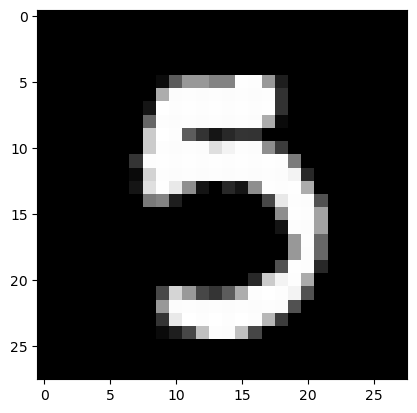

In [137]:
label_ls=labels.tolist()
print(label_ls[0])
plt.imshow(images[0].reshape(28,28),label=label_ls[0], cmap="gray")

In [6]:
trainloader = DataLoader(DatasetSplit(train_dataset, idxs_train),
                                 batch_size=128, shuffle=True)

NameError: name 'self' is not defined